pde loss: 3.55e-02 | bc loss: 9.86e-02 | loss: 9.90e-02 : 100%|██████████| 20/20 [00:43<00:00,  2.18s/it]


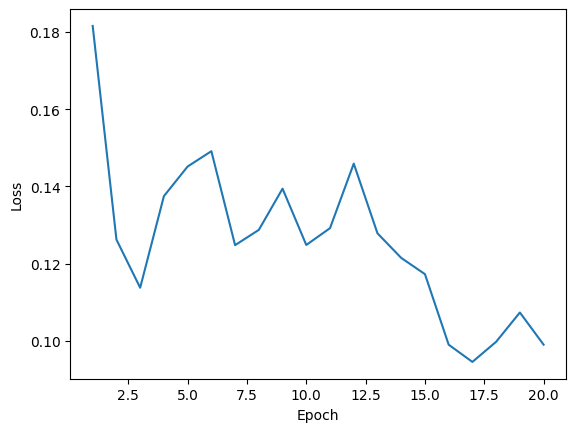

In [1]:
from kan import *
import torch
from torch import autograd
from tqdm import tqdm
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

model = KAN(width=[2,2,1])
loss = torch.nn.MSELoss()
steps = 20
alpha = 0.01
his_loss=[]

def interior(n=1000):
    x = torch.rand(n, 1)
    y = torch.rand(n, 1)
    cond = (2 - x ** 2) * torch.exp(-y)
    return x.requires_grad_(True), y.requires_grad_(True), cond


def down_yy(n=100):
    x = torch.rand(n, 1)
    y = torch.zeros_like(x)
    cond = x ** 2
    return x.requires_grad_(True), y.requires_grad_(True), cond


def up_yy(n=100):
    x = torch.rand(n, 1)
    y = torch.ones_like(x)
    cond = x ** 2 / torch.e
    return x.requires_grad_(True), y.requires_grad_(True), cond


def down(n=100):
    x = torch.rand(n, 1)
    y = torch.zeros_like(x)
    cond = x ** 2
    return x.requires_grad_(True), y.requires_grad_(True), cond


def up(n=100):
    x = torch.rand(n, 1)
    y = torch.ones_like(x)
    cond = x ** 2 / torch.e
    return x.requires_grad_(True), y.requires_grad_(True), cond


def left(n=100):
    y = torch.rand(n, 1)
    x = torch.zeros_like(y)
    cond = torch.zeros_like(x)
    return x.requires_grad_(True), y.requires_grad_(True), cond


def right(n=100):
    y = torch.rand(n, 1)
    x = torch.ones_like(y)
    cond = torch.exp(-y)
    return x.requires_grad_(True), y.requires_grad_(True), cond

def l_interior(u):
    x, y, cond = interior()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(gradients(uxy, x, 2) - gradients(uxy, y, 4), cond)


def l_down_yy(u):
    x, y, cond = down_yy()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(gradients(uxy, y, 2), cond)


def l_up_yy(u):
    x, y, cond = up_yy()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(gradients(uxy, y, 2), cond)


def l_down(u):
    x, y, cond = down()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l_up(u):
    x, y, cond = up()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l_left(u):
    x, y, cond = left()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l_right(u):
    x, y, cond = right()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def true_equation(x):
    return torch.exp(-x[:,1])*x[:,0]**2


def gradients(u, x, order=1):
    if order==1:
        return autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    else:
        return gradients(gradients(u,x), x, order=order-1)


def train():
    optimizer = LBFGS(model.parameters(), lr=1, line_search_fn="strong_wolfe")

    pbar = tqdm(range(steps), desc='description')

    for _ in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()
            # interior loss
            pde_loss = l_interior(model)

            # boundary loss
            bc_loss = l_interior(model)+l_up_yy(model)+l_down_yy(model)+l_up(model)+l_down(model)+l_left(model)+l_right(model)

            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        optimizer.step(closure)
        loss = alpha * pde_loss + bc_loss
        his_loss.append(loss.item())

        pbar.set_description("pde loss: %.2e | bc loss: %.2e | loss: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), loss.detach().numpy()))
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(range(1,steps+1),his_loss)
    plt.show()

train()

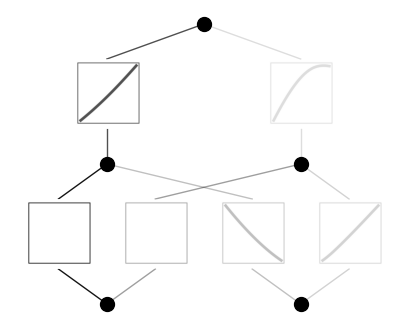

In [2]:
model.plot()

In [6]:
model.auto_symbolic()

fixing (0,0,0) with gaussian, r2=0.9999988937886085
fixing (0,0,1) with sin, r2=0.9999795080264173
fixing (0,1,0) with sin, r2=0.9999995907716975
fixing (0,1,1) with gaussian, r2=0.9999839768853797
fixing (1,0,0) with cosh, r2=0.9999838598565443
fixing (1,1,0) with sin, r2=0.9999863043610622


pde loss: 1.23e-02 | bc loss: 2.12e-02 | loss: 2.14e-02 : 100%|██████████| 20/20 [01:07<00:00,  3.36s/it]


ValueError: x and y must have same first dimension, but have shapes (20,) and (40,)

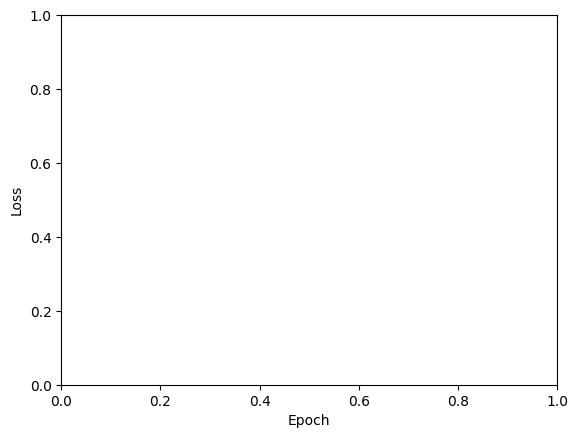

In [7]:
train()

In [8]:
formula = model.symbolic_formula()[0][0]
formula

-0.1*sin(1.48*sin(2.09*x_1 + 7.97) + 2.2 + 2.73*exp(-0.25*(-0.39*x_2 - 1)**2)) + 0.16*cosh(1.22*sin(0.64*x_2 - 6.04) - 3.7 + 3.07*exp(-0.91*(-x_1 - 0.26)**2)) - 0.26

/Users/lihaoyang/anaconda3/envs/pykan/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


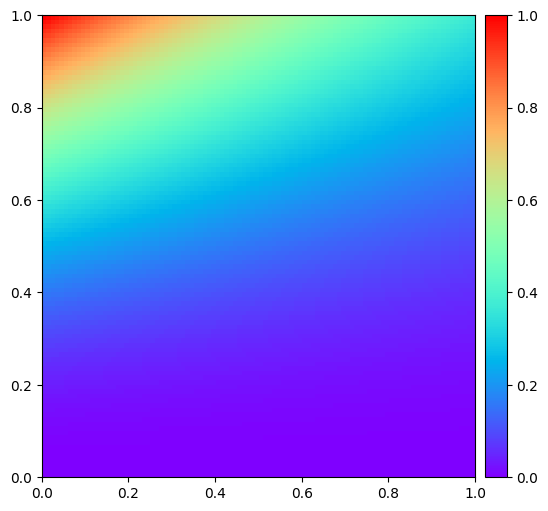

In [3]:
def plot_true():
        """ plot the solution on new data """

        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        x = torch.linspace(0, 1, 100)
        t = torch.linspace(0, 1, 100)

        # x & t grids:
        X, T = torch.meshgrid(x, t, indexing=None)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        x_i = torch.stack([xcol.reshape(-1,), tcol.reshape(-1,)]).permute(1,0)

        # one large column:
        true_sol = true_equation(x_i)

        # reshape solution:
        U = true_sol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()],
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.savefig('./pde_true.png')
        plt.show()

plot_true()

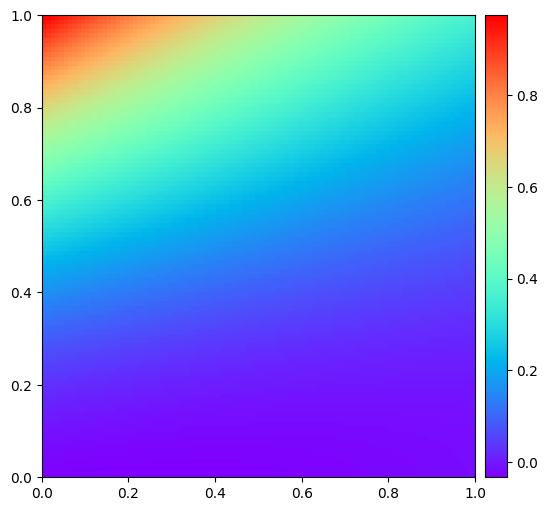

In [9]:
def plot_kan(model):
        """ plot the solution on new data """

        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        x = torch.linspace(0, 1, 100)
        t = torch.linspace(0, 1, 100)

        # x & t grids:
        X, T = torch.meshgrid(x, t, indexing=None)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        x_i = torch.stack([xcol.reshape(-1,), tcol.reshape(-1,)]).permute(1,0)

        # one large column:
        kan_sol = model(x_i)

        # reshape solution:
        U = kan_sol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[0,1,0,1],
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.savefig('./pde_kan.png')
        plt.show()

plot_kan(model)

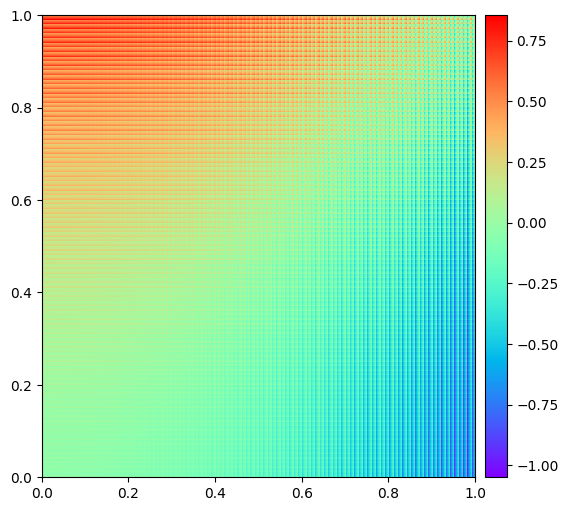

In [5]:
def plot_dif(model):
        """ plot the solution on new data """

        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        x = torch.linspace(0, 1, 100)
        t = torch.linspace(0, 1, 100)

        # x & t grids:
        X, T = torch.meshgrid(x, t, indexing=None)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        x_i = torch.hstack([xcol, tcol])

        # one large column:
        kan_sol = model(x_i)
        true_sol = true_equation(x_i)
        dif = kan_sol - true_sol

        # reshape solution:
        U = dif.reshape(x.numel()*t.numel(),-1)

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()],
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.savefig('./pde_dif.png')
        plt.show()

plot_dif(model)